<a href="https://colab.research.google.com/github/EugeneDyachenko/ml-study-cats-vs-dogs-transer-learning-notebook/blob/master/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Solving classigication problem Cats vs Dogs

Dataset: https://www.kaggle.com/biaiscience/dogs-vs-cats

In [1]:
import os

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, RandomFlip, RandomRotation
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [2]:
DATASET_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_dataset = tf.keras.utils.get_file('cats_and_dogs.zip', origin=DATASET_URL, extract=True)
datset_dir = os.path.join(os.path.dirname(path_to_dataset), 'cats_and_dogs_filtered')
train_dir = os.path.join(datset_dir, 'train')
validation_dir = os.path.join(datset_dir, 'validation')

IMAGE_SIZE = 224
BATCH_SIZE = 32
SEED = 24
VALIDATION_SPLIT = 0.2
LABEL_MODE = 'int'
SHUFFLE = True
BUFFER_SIZE = tf.data.experimental.AUTOTUNE

train_data = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    shuffle=SHUFFLE,
    subset='training',
    seed=SEED,
    label_mode=LABEL_MODE
).cache().prefetch(BUFFER_SIZE)

validation_data = keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=VALIDATION_SPLIT,
    shuffle=SHUFFLE,
    subset='validation',
    seed=SEED,
    label_mode=LABEL_MODE
).cache().prefetch(BUFFER_SIZE)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Found 2000 files belonging to 2 classes.
Using 400 files for validation.


# Data
We have 2000 examples belongs to 2 clasees: Cat and Dog. I will use 80% for training and remaining 20% for validation. Let's plot some images.

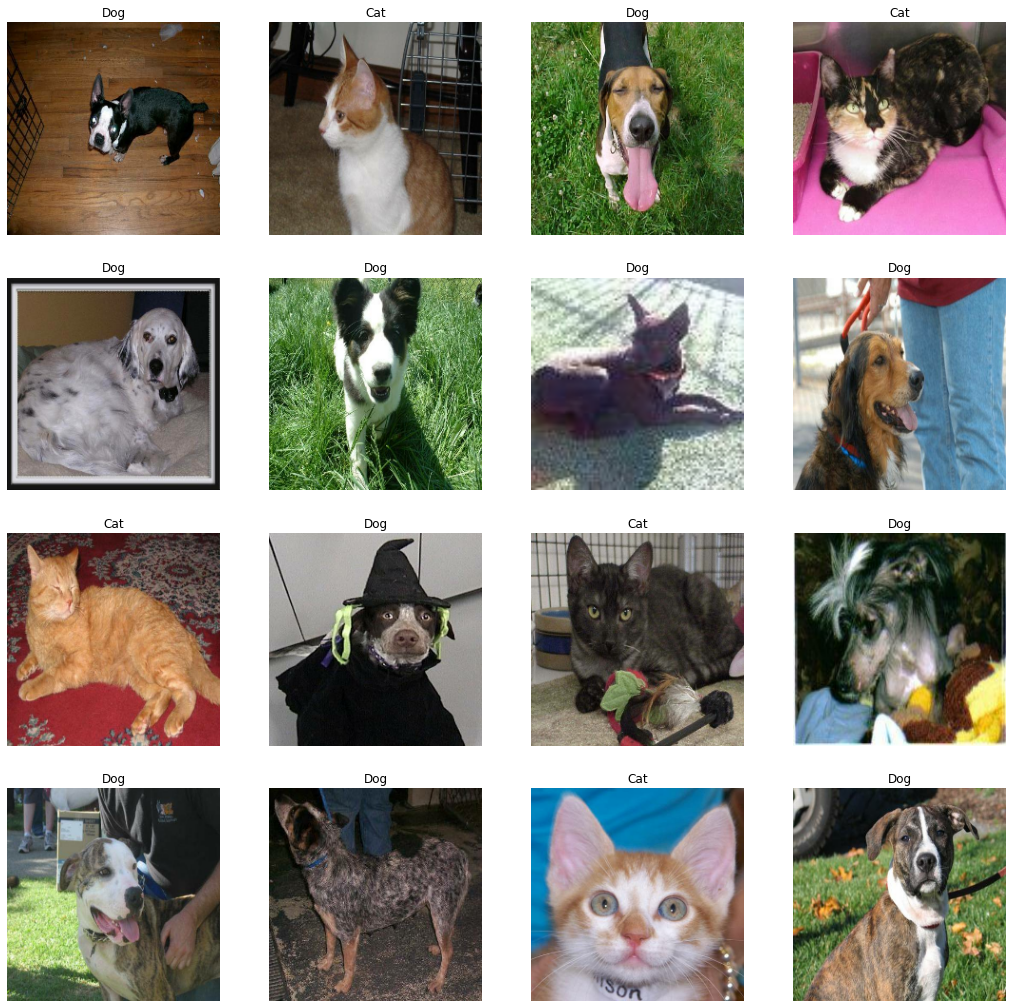

In [3]:
CLASSES = {
    0: 'Cat',
    1: 'Dog'
}
images, labels = list(train_data.take(1).as_numpy_iterator())[0]

plt.figure(figsize=(18, 18))

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.axis("off")
  plt.imshow(images[i].astype(np.uint8))
  plt.title(CLASSES[labels[i]])

plt.show()

# Data augmentation
Random horizontal flips and rotation up to 125 degrees.

In [4]:
data_augmentation = tf.keras.Sequential([
  RandomFlip('horizontal', input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)),
  RandomRotation(0.2),
], name='data_augmentation')

# Data preprocessing
Rescaling to range [0, 1] applies for input data

In [5]:
data_preprocessing = tf.keras.Sequential([
  Rescaling(1./255, name='rescaling')
], name='preprocessing')

# Models

Here I want to compare 4 models:
* Simple Dense model
* Simple CNN model
* Model using transfer learning


# Training
* For training will be used Adam optimizer and BinaryCrossentropy
* All models will have same data augmentation and learning parameters. 
* Models will be trained on small dataset with only 2000 examples

In [6]:
def compile_model(model):
  optimizer = keras.optimizers.Adam(0.00005)
  loss = keras.losses.BinaryCrossentropy(from_logits=True)

  model.compile(
      optimizer=optimizer,
      loss=loss,
      metrics=['accuracy']
  )

In [7]:
def train_model(model, epochs = 100):
  history = None

  early_stopping_callback = tf.keras.callbacks.EarlyStopping(patience=10)

  with tf.device('/GPU:0'):
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=validation_data,
        verbose=2,
        callbacks=[early_stopping_callback]
    )

  return history

In [8]:
def visualize_training(history, epochs):
  epochs_range = range(1, len(history.history['accuracy']) + 1)

  plt.figure(figsize=(8, 16))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, history.history['accuracy'], label='Accuracy')
  plt.plot(epochs_range, history.history['val_accuracy'], label='Validation accuracy')
  plt.legend()
  plt.xlabel('Epoch')
  plt.title('Accuracy')
  plt.show()

  plt.figure(figsize=(8, 16))
  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, history.history['loss'], label='Loss')
  plt.plot(epochs_range, history.history['val_loss'], label='Validation_loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.title('Loss')
  plt.show()

In [9]:
def run_model(model, epochs=100):
  compile_model(model)
  history = train_model(model, epochs)
  visualize_training(history, epochs)

# Dense Model
- Simple Dense model with 5 layers and relu activations
- 38 millions neurons

In [10]:
def create_dense_model():
  model = keras.Sequential()

  model.add(data_augmentation)
  model.add(data_preprocessing)
  model.add(Flatten(name='flatten'))

  model.add(Dense(256, activation='relu', name='dense_1'))
  
  model.add(Dense(128, activation='relu', name='dense_2'))

  model.add(Dense(64, activation='relu', name='dense_3'))

  model.add(Dense(32, activation='relu', name='dense_4'))

  model.add(Dense(1, name='dense_5'))

  return model

print(create_dense_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
preprocessing (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               38535424  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2

Epoch 1/100
50/50 - 4s - loss: 0.7281 - accuracy: 0.5013 - val_loss: 0.7691 - val_accuracy: 0.5100
Epoch 2/100
50/50 - 1s - loss: 0.7180 - accuracy: 0.5250 - val_loss: 0.7020 - val_accuracy: 0.5350
Epoch 3/100
50/50 - 1s - loss: 0.6980 - accuracy: 0.5275 - val_loss: 0.7054 - val_accuracy: 0.5400
Epoch 4/100
50/50 - 1s - loss: 0.6960 - accuracy: 0.5294 - val_loss: 0.6948 - val_accuracy: 0.5500
Epoch 5/100
50/50 - 1s - loss: 0.6939 - accuracy: 0.5275 - val_loss: 0.7218 - val_accuracy: 0.5800
Epoch 6/100
50/50 - 1s - loss: 0.7194 - accuracy: 0.5331 - val_loss: 0.6966 - val_accuracy: 0.5175
Epoch 7/100
50/50 - 1s - loss: 0.6904 - accuracy: 0.5425 - val_loss: 0.6844 - val_accuracy: 0.5300
Epoch 8/100
50/50 - 1s - loss: 0.6889 - accuracy: 0.5481 - val_loss: 0.6778 - val_accuracy: 0.5275
Epoch 9/100
50/50 - 1s - loss: 0.7021 - accuracy: 0.5487 - val_loss: 0.6779 - val_accuracy: 0.5325
Epoch 10/100
50/50 - 1s - loss: 0.6877 - accuracy: 0.5381 - val_loss: 0.7037 - val_accuracy: 0.5850
Epoch 11/

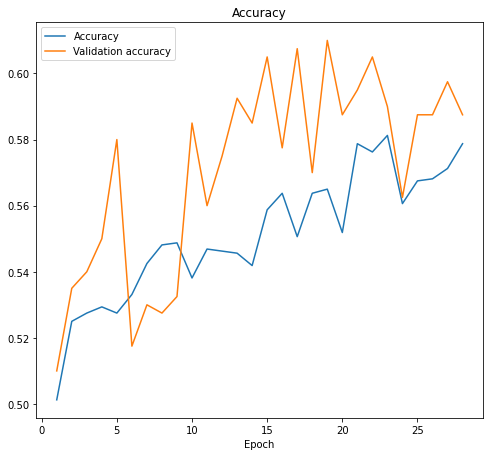

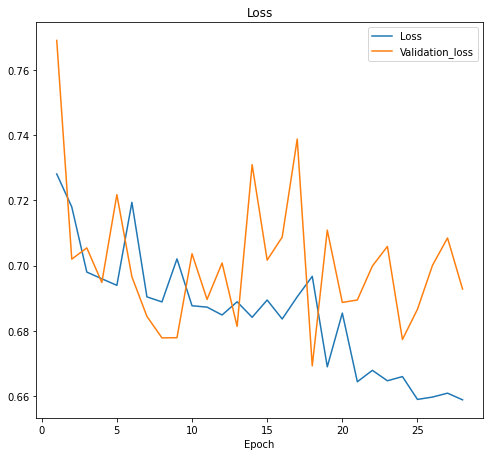

In [11]:
run_model(create_dense_model())

## Results
* 60.75% best accuracy on validation set.
* Early stoppin on 28th epoch.

Dense model is not effective for this task. Model has too many parameters and cannot provide significante perfomance.

# CNN model
- 3 Convolutional layers and 2 Dense layers
- 12 millons neurons

In [12]:
def create_cnn_model():
  model = keras.Sequential()

  model.add(data_augmentation)
  model.add(data_preprocessing)

  model.add(Conv2D(32, kernel_size=(3,3), padding='same', name='conv_1_1'))
  model.add(MaxPool2D(pool_size=(2, 2), name='maxpool_1'))

  model.add(Conv2D(64, kernel_size=(3,3), padding='same', name='conv_2_1'))
  model.add(MaxPool2D(pool_size=(2, 2), name='maxpool_2'))

  model.add(Conv2D(128, kernel_size=(3,3), padding='same', name='conv_3_1'))
  model.add(MaxPool2D(pool_size=(2, 2), name='maxpool_3'))
  
  model.add(Flatten(name='flatten'))
  model.add(Dense(128, activation='relu', name='dense_4'))
  model.add(Dense(1, name='dense_5'))

  return model

print(create_cnn_model().summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
preprocessing (Sequential)   (None, 224, 224, 3)       0         
_________________________________________________________________
conv_1_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 112, 112, 32)      0         
_________________________________________________________________
conv_2_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 56, 56, 64)        0         
_________________________________________________________________
conv_3_1 (Conv2D)            (None, 56, 56, 128)      

Epoch 1/100
50/50 - 2s - loss: 0.7106 - accuracy: 0.5113 - val_loss: 0.6706 - val_accuracy: 0.5150
Epoch 2/100
50/50 - 2s - loss: 0.6708 - accuracy: 0.5387 - val_loss: 0.6589 - val_accuracy: 0.5975
Epoch 3/100
50/50 - 2s - loss: 0.6580 - accuracy: 0.5725 - val_loss: 0.6526 - val_accuracy: 0.6150
Epoch 4/100
50/50 - 2s - loss: 0.6524 - accuracy: 0.5806 - val_loss: 0.6392 - val_accuracy: 0.6075
Epoch 5/100
50/50 - 2s - loss: 0.6423 - accuracy: 0.5881 - val_loss: 0.6298 - val_accuracy: 0.6225
Epoch 6/100
50/50 - 2s - loss: 0.6362 - accuracy: 0.5956 - val_loss: 0.6234 - val_accuracy: 0.6350
Epoch 7/100
50/50 - 2s - loss: 0.6277 - accuracy: 0.6106 - val_loss: 0.6155 - val_accuracy: 0.6350
Epoch 8/100
50/50 - 2s - loss: 0.6309 - accuracy: 0.6019 - val_loss: 0.6153 - val_accuracy: 0.6175
Epoch 9/100
50/50 - 2s - loss: 0.6235 - accuracy: 0.6050 - val_loss: 0.6088 - val_accuracy: 0.6550
Epoch 10/100
50/50 - 2s - loss: 0.6177 - accuracy: 0.6137 - val_loss: 0.6083 - val_accuracy: 0.6650
Epoch 11/

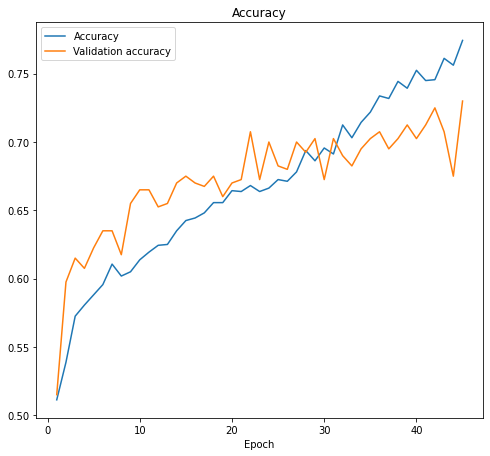

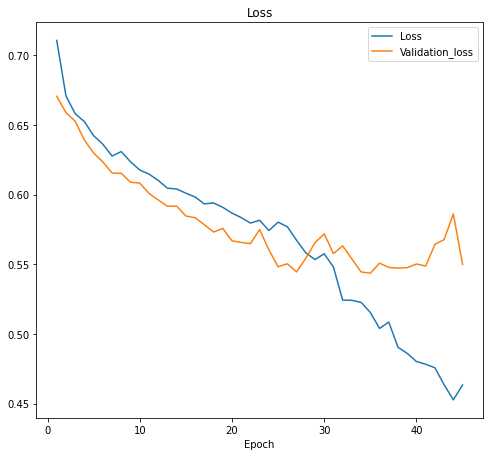

In [13]:
run_model(create_cnn_model())

## Results
- 73% best accuracy on validation set.
- Early stopping on 45th epoch.

Model has better permonace than Dense model and lower number of parameters. This model is much better for our classifitcation problem.

# Pretrained model
* Pretrained VGG16 model without last layer
* Two trainable dense layer for classification
* 17m parameters, only 3 millions are trainable

In [14]:
def create_pretrained_model():
  pretrained_layers_url ="https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
  
  pretrained_layers = keras.applications.vgg16.VGG16(include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
  pretrained_layers.trainable = False

  model = keras.Sequential()
  
  model.add(data_augmentation)
  model.add(pretrained_layers)
  model.add(Flatten(name='flatten'))
  model.add(Dense(128, activation='relu', name='dense_1'))
  model.add(Dense(1, name='dense_2'))
  
  return model

print(create_pretrained_model().summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 17,926,209
Trainable params: 3,211,521
Non-trainable params: 14,714,688
_________________________________________________________________
None


Epoch 1/100
50/50 - 4s - loss: 1.8181 - accuracy: 0.7931 - val_loss: 0.6778 - val_accuracy: 0.9200
Epoch 2/100
50/50 - 4s - loss: 0.7920 - accuracy: 0.8894 - val_loss: 0.4493 - val_accuracy: 0.9475
Epoch 3/100
50/50 - 4s - loss: 0.5555 - accuracy: 0.9162 - val_loss: 0.3898 - val_accuracy: 0.9600
Epoch 4/100
50/50 - 4s - loss: 0.4108 - accuracy: 0.9256 - val_loss: 0.3566 - val_accuracy: 0.9575
Epoch 5/100
50/50 - 4s - loss: 0.3605 - accuracy: 0.9350 - val_loss: 0.3368 - val_accuracy: 0.9600
Epoch 6/100
50/50 - 4s - loss: 0.2312 - accuracy: 0.9525 - val_loss: 0.3326 - val_accuracy: 0.9625
Epoch 7/100
50/50 - 4s - loss: 0.2331 - accuracy: 0.9481 - val_loss: 0.3235 - val_accuracy: 0.9575
Epoch 8/100
50/50 - 4s - loss: 0.1873 - accuracy: 0.9588 - val_loss: 0.2821 - val_accuracy: 0.9600
Epoch 9/100
50/50 - 4s - loss: 0.1992 - accuracy: 0.9544 - val_loss: 0.3253 - val_accuracy: 0.9575
Epoch 10/100
50/50 - 4s - loss: 0.1697 - accuracy: 0.9588 - val_loss: 0.3943 - val_accuracy: 0.9475
Epoch 11/

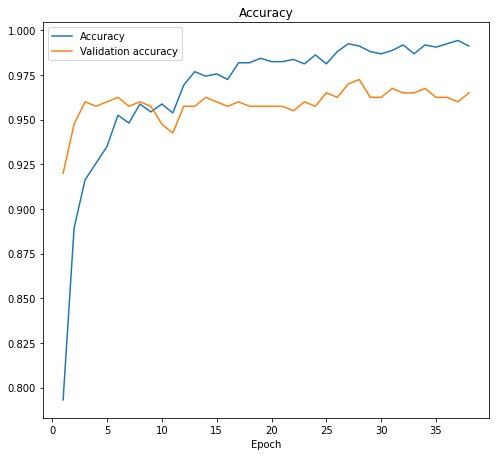

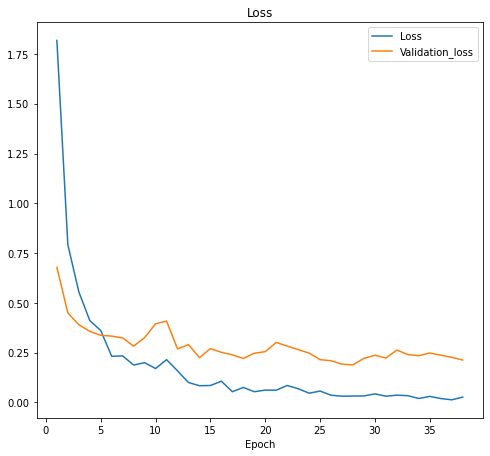

In [15]:
run_model(create_pretrained_model())

Results
* 97.25% accuracy on validation set
* Early stopping on 38th epoch

Transfer learning and using pretrained model has signifacanly improved our perfomance and reduced training time. It's the best model for our task.

# Conclusions
- Dense networks are not effective for real-world images problem. They have too large numbers of neourones when input image has significat size.
- CNN much more effective for solving image problems
- Using pretrained network can save training time and computation power. And provide good perfomance on small datasets. 